# Notebook for reformatting multimodal datasets (RNA+CITE) 

We use RNA/GEX, CITE/ADT interchangeably.

This is very similar to RNA+ATAC notebook in terms of the fact that the cells are shared between the two modalities. We just need to be careful with the following
- (1) cell_id being consistent when merging
- (2) each modalities are normalized separately
- (3) keeping the embeddings from both modalities.

## Note that this object is already concatenated with multiple donors, as well as the count matrix already has the form of cell x (RNA+CITE) format.

What we will do:
- subset for only one site/donor (s1d1)
- rename the var with each modality (either RNA or ADT)
- redo the log-normalization for each modality, then merge (this is pretty much for visualization only)

In [3]:
import numpy as np
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import tqdm
import sys
import os
from scipy import sparse

In [2]:
adata = sc.read_h5ad("/mnt/ibm_lg/yangjoon.kim/excellxgene_tutorial_manuscript/data/neurips2021_cite/cite_BMMC_processed.h5ad")
adata

/home/yangjoon.kim/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 90261 × 14087
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id'
    uns: 'dataset_id', 'genome', 'organism'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [5]:
adata.obs.batch

GCATTAGCATAAGCGG-1-s1d1    s1d1
TACAGGTGTTAGAGTA-1-s1d1    s1d1
AGGATCTAGGTCTACT-1-s1d1    s1d1
GTAGAAAGTGACACAG-1-s1d1    s1d1
TCCGAAAAGGATCATA-1-s1d1    s1d1
                           ... 
GAATCACCACGGAAGT-1-s4d9    s4d9
GCTGGGTGTACGGATG-1-s4d9    s4d9
TCGAAGTGTGACAGGT-1-s4d9    s4d9
GCAGGCTGTTGCATAC-1-s4d9    s4d9
ACGTAACAGGTCTACT-1-s4d9    s4d9
Name: batch, Length: 90261, dtype: category
Categories (12, object): ['s1d1', 's1d2', 's1d3', 's2d1', ..., 's3d7', 's4d1', 's4d8', 's4d9']

In [27]:
# subset for one dataset - s1d1 using the "batch" key. Note that we can also use "Site" and "DonorNumber" keys.
adata_s1d1 = adata[adata.obs.batch=="s1d1"]

adata_s1d1

del adata

View of AnnData object with n_obs × n_vars = 5227 × 14087
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id'
    uns: 'dataset_id', 'genome', 'organism'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

# Exploration of the data - double check how the data was post-processed

In [29]:
# check the if adata.obsm field was also subsetted properly. It was.
len(adata_s1d1.obsm["GEX_X_umap"])

5227

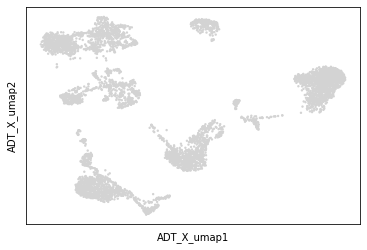

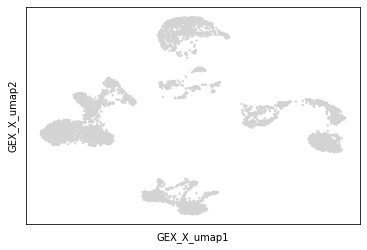

In [40]:
sc.pl.embedding(adata_s1d1, basis="ADT_X_umap")
sc.pl.embedding(adata_s1d1, basis="GEX_X_umap")

Check each feature type in the adata.var

In [75]:
adata_s1d1[:,adata_s1d1.var_names=="CD4"].var

,feature_types,gene_id
CD4,GEX,ENSG00000010610
CD4,ADT,ENSG00000010610


In [31]:
adata_s1d1.var[adata_s1d1.var.feature_types=="ADT"]

,feature_types,gene_id
CD86,ADT,ENSG00000114013
CD274,ADT,NaN
CD270,ADT,NaN
CD155,ADT,NaN
CD112,ADT,NaN
...,...,...
HLA-E,ADT,ENSG00000204592
CD82,ADT,ENSG00000085117
CD101,ADT,ENSG00000134256
CD88,ADT,NaN


In [37]:
# This chunk of code didn't work - it did not change the original adata's var_name.
# # change the var names for GEX assay
# adata_s1d1[:,adata_s1d1.var.feature_types=="GEX"].var_names = \
#     adata_s1d1[:,adata_s1d1.var.feature_types=="GEX"].var_names+"-RNA"
# adata_s1d1[:,adata_s1d1.var.feature_types=="GEX"].var_names

# # change the var names for ADT assay
# adata_s1d1[:,adata_s1d1.var.feature_types=="ADT"].var_names = \
#     adata_s1d1[:,adata_s1d1.var.feature_types=="ADT"].var_names+"-ADT"
# adata_s1d1[:,adata_s1d1.var.feature_types=="ADT"].var_names

Index(['CD86', 'CD274', 'CD270', 'CD155', 'CD112', 'CD47', 'CD48', 'CD40',
       'CD154', 'CD52',
       ...
       'CD94', 'CD162', 'CD85j', 'CD23', 'CD328', 'HLA-E', 'CD82', 'CD101',
       'CD88', 'CD224'],
      dtype='object', length=134)

In [38]:
# change the var names for GEX assay
adata_s1d1.var_names

Index(['AL627309.5', 'LINC01409', 'LINC01128', 'LINC00115', 'FAM41C', 'NOC2L',
       'KLHL17', 'HES4', 'ISG15', 'AGRN',
       ...
       'CD94', 'CD162', 'CD85j', 'CD23', 'CD328', 'HLA-E', 'CD82', 'CD101',
       'CD88', 'CD224'],
      dtype='object', length=14087)

# Subset the data for each modality (assay) - RNA and ADT

## GEX

In [87]:
# subset for GEX assay
adata_GEX = adata_s1d1[:,adata_s1d1.var.feature_types=="GEX"]

In [93]:
# recover the raw counts in the adata_GEX.X
adata_GEX.X = adata_GEX.layers["counts"].copy()

# log-normalization for RNA(GEX) counts
sc.pp.normalize_total(adata_GEX, target_sum=1e4)
sc.pp.log1p(adata_GEX)
adata_GEX.raw = adata_GEX.copy()


In [96]:
# check the log-normalization
np.sum(np.expm1(adata_GEX.X.todense()),1)

matrix([[10000.   ],
        [ 9999.999],
        [10000.   ],
        ...,
        [10000.   ],
        [10000.   ],
        [10000.   ]], dtype=float32)

In [90]:
# Add the modality/assay to the var_names 
adata_GEX.var_names = adata_GEX.var_names+"-RNA"
adata_GEX.var_names

Index(['AL627309.5-RNA', 'LINC01409-RNA', 'LINC01128-RNA', 'LINC00115-RNA',
       'FAM41C-RNA', 'NOC2L-RNA', 'KLHL17-RNA', 'HES4-RNA', 'ISG15-RNA',
       'AGRN-RNA',
       ...
       'MT-ND3-RNA', 'MT-ND4L-RNA', 'MT-ND4-RNA', 'MT-ND5-RNA', 'MT-ND6-RNA',
       'MT-CYB-RNA', 'AC011043.1-RNA', 'AL592183.1-RNA', 'AC240274.1-RNA',
       'AC007325.4-RNA'],
      dtype='object', length=13953)

In [91]:
adata_GEX

AnnData object with n_obs × n_vars = 5227 × 13953
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id'
    uns: 'dataset_id', 'genome', 'organism', 'log1p'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

## ADT

Note that ADT counts should be Centered-log-ratio (CLR) transformed, rather than log-normalization transformed.
Find the rationale in this thread - https://github.com/satijalab/seurat/issues/3550
In short, due to non-specific binding background signal from ADT(CITE-seq), log-normalization is not preferred. (Why is this a good rationale?)

A review paper on transformation/normalization methods: https://academic.oup.com/bioinformatics/article/34/16/2870/4956011

Also see Stoeckius et al., 2017, the first CITE-seq paper.

In [98]:
# Muon package contains some normalization methods specific to CITE-seq
# ref: https://muon.readthedocs.io/en/latest/omics/citeseq.html#clr
from muon import prot as pt

2023-01-05 21:25:36.629997: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [84]:
adata_ADT = adata_s1d1[:,adata_s1d1.var.feature_types=="ADT"]
adata_ADT

View of AnnData object with n_obs × n_vars = 5227 × 134
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id'
    uns: 'dataset_id', 'genome', 'organism'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [99]:
# Recover the raw counts in ADT
adata_ADT.X = adata_ADT.layers["counts"].copy()

In [101]:
# Centered-log-ratio transform (CLR-transform)
pt.pp.clr(adata_ADT)

/home/yangjoon.kim/miniconda3/lib/python3.9/site-packages/muon/_prot/preproc.py:214: UserWarning: adata.X is sparse but not in CSC format. Converting to CSC.
  warn("adata.X is sparse but not in CSC format. Converting to CSC.")


In [102]:
adata_ADT.X.todense()

matrix([[0.31639194, 0.2286106 , 0.5671788 , ..., 0.05678363, 0.3251227 ,
         0.31217906],
        [3.066621  , 1.0288934 , 1.0341814 , ..., 2.254477  , 0.7053399 ,
         2.3608222 ],
        [0.        , 0.41456035, 0.740614  , ..., 0.        , 0.3251227 ,
         0.2570575 ],
        ...,
        [0.55637395, 0.57129455, 0.64521736, ..., 0.5977231 , 0.22803849,
         0.591158  ],
        [3.1655698 , 1.2721524 , 1.0838095 , ..., 2.925572  , 2.0359435 ,
         2.1018665 ],
        [0.55637395, 0.82604325, 0.6198752 , ..., 0.3835018 , 0.57007575,
         0.591158  ]], dtype=float32)

In [103]:
# Add the modality/assay to the var_names 
adata_ADT.var_names = adata_ADT.var_names+"-ADT"
adata_ADT.var_names

Index(['CD86-ADT', 'CD274-ADT', 'CD270-ADT', 'CD155-ADT', 'CD112-ADT',
       'CD47-ADT', 'CD48-ADT', 'CD40-ADT', 'CD154-ADT', 'CD52-ADT',
       ...
       'CD94-ADT', 'CD162-ADT', 'CD85j-ADT', 'CD23-ADT', 'CD328-ADT',
       'HLA-E-ADT', 'CD82-ADT', 'CD101-ADT', 'CD88-ADT', 'CD224-ADT'],
      dtype='object', length=134)

# Merge the two adata objects (RNA and ADT)

In [124]:
del adata_GEX.raw

In [125]:
# concatenate the two adata objects
adata_joint = ad.concat([adata_GEX, adata_ADT], axis=1, merge="first")
adata_joint

AnnData object with n_obs × n_vars = 5227 × 14087
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [158]:
adata_test = adata_joint.copy()

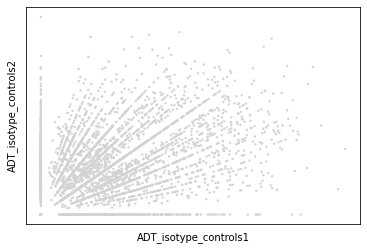

In [163]:
sc.pl.embedding(adata_test, basis="ADT_isotype_controls")

In [167]:
del adata_joint.obsm["ADT_isotype_controls"]

In [172]:
adata_joint.var

,feature_types,gene_id
AL627309.5-RNA,GEX,ENSG00000241860
LINC01409-RNA,GEX,ENSG00000237491
LINC01128-RNA,GEX,ENSG00000228794
LINC00115-RNA,GEX,ENSG00000225880
FAM41C-RNA,GEX,ENSG00000230368
...,...,...
HLA-E-ADT,ADT,ENSG00000204592
CD82-ADT,ADT,ENSG00000085117
CD101-ADT,ADT,ENSG00000134256
CD88-ADT,ADT,NaN


In [176]:
# the fact that there were too many categorical variables in adata.var["gene_id"] was the issue that failed exCellxgene (and also Cellxgene)
# Thus, we will get rid of this field for now.
adata_joint.var = adata_joint.var.drop(columns= "gene_id")

In [177]:
adata_joint.var

,feature_types
AL627309.5-RNA,GEX
LINC01409-RNA,GEX
LINC01128-RNA,GEX
LINC00115-RNA,GEX
FAM41C-RNA,GEX
...,...
HLA-E-ADT,ADT
CD82-ADT,ADT
CD101-ADT,ADT
CD88-ADT,ADT


In [161]:
# del adata_test.obsm["ADT_X_pca"]
# del adata_test.obsm["GEX_X_pca"]
# del adata_test.obsm["ADT_isotype_controls"]

In [151]:
adata_GEX.write_h5ad("/mnt/ibm_lg/yangjoon.kim/excellxgene_tutorial_manuscript/data/neurips2021_cite/s1d1_gex_lognorm_transformed.h5ad")

In [129]:
adata_ADT.write_h5ad("/mnt/ibm_lg/yangjoon.kim/excellxgene_tutorial_manuscript/data/neurips2021_cite/s1d1_cite_CLR_transformed.h5ad")

In [178]:
adata_joint.write_h5ad("/mnt/ibm_lg/yangjoon.kim/excellxgene_tutorial_manuscript/data/neurips2021_cite/s1d1_gex_cite_joint_normalized_per_assay.h5ad")